In [1]:
from MDP import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from math import floor

(Creating Willemsen Gridworld)


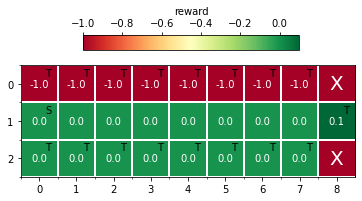

In [2]:
# Create the gridworld, and set cell values to equal rewards
print('(Creating Willemsen Gridworld)')
grid = np.ones((3, 9)) * -1
grid[1,:8] = 0
grid[1, 8] = 0.1
grid[2, :8] = 0
terminal_state = []
for i in [0,2]:
    for j in range(8):
        terminal_state.append([i,j])
terminal_state.append([1,8])
terminal_state = np.array(terminal_state)
initial_state = np.array([1, 0])
blacked_state = np.array([[0, 8],[2, 8]])

fig, ax, im, cb = plot_gridworld(grid, terminal_state, initial_state, blacked_state, fig=None, ax=None, show=True)

n_episodes = 100
max_steps = 40
gamma = 0.8
alpha = 0.1
epsilon = 0.05

Learn = True
batch_size = 1

env = Gridworld(grid, terminal_state, initial_state, blacked_state, max_steps)

In [3]:
class Agent:
    def __init__(self, batch_size=1):
        self.actions = ['up', 'down', 'left', 'right']
        self.n_actions = len(self.actions)
        self.actions_map = {action: i for i, action in enumerate(self.actions)}
        self.trajectory = []
        self.batch_size = batch_size
        self.estimators = [Estimator(approximator=bellman_Q_table(alpha=0.1, gamma=0.8), mask=identity())]
        self.buffer = ReplayMemory(max_size=10000)
        self.target = [Target()]
        self.counter = state_table()

    def select_action(self, transition):
        self.process_state_estimators(transition)
        action = self.combine_state_estimators(transition)
        return action

    def observe(self, transition):
        self.trajectory.append(transition)
        self.update_counter(transition)
        for E in self.estimators:
            E.count_visits(transition)
        if transition.terminal:
            T = self.compute_trajectory_targets(self.trajectory)
            self.store_trajectory(self.trajectory, T)

    def process_state_estimators(self, transition):
        if self.buffer.size > self.batch_size:
            S = self.buffer.sample(self.batch_size)
            for E in self.estimators:
                E.update(S)

    def combine_state_estimators(self, transition):
        action = self.actions[np.random.randint(self.n_actions)]
        return action

    def update_counter(self, transition):
        self.counter.update_table(transition)
        self.counter.update_value(transition)

    def compute_trajectory_targets(self, trajectory):
        for target in self.targets:
            target.compute(trajectory)
        return 0

    def store_trajectory(self, trajectory, targets):
        for transition in trajectory:
            transition.targets = targets
            self.buffer.append(transition)

    def reset_trajectory(self):
        self.trajectory = []


class Greedy(Agent):
    def __init__(self, batch_size=10):
        super().__init__(batch_size)
        self.estimators = [Estimator(approximator=bQt_novel_alpha(gamma=0.8), mask=identity()), 
                           Estimator(approximator=bellman_N_table(alpha=0.1, gamma=0.8), mask=identity())]
        self.buffer = ReplayMemory(max_size=10000)
        self.targets = [Target()]
        self.counter = state_table()
        
    def combine_state_estimators(self, transition):
        maximizing_actions = []
        for E in self.estimators:
            action_values = E.evaluate(transition)
            max_value = max(action_values.values())
            max_actions = [k for k,v in action_values.items() if v == max_value]
            maximizing_actions.append(np.random.choice(max_actions))
        return np.random.choice(maximizing_actions)

In [4]:
class global_context(Mask):
    def apply(self, transition):
        context = 0
        return context

class Noveltor(Agent):
    def __init__(self, batch_size=10):
        super().__init__(batch_size)
        self.estimators = [Estimator(approximator=bQt_novel_alpha(gamma=0.8), mask=identity()), 
                           Estimator(approximator=bellman_N_table(alpha=0.1, gamma=0.8), mask=identity()),
                           Estimator(ema(), mask=global_context())]
        self.buffer = ReplayMemory(max_size=10000)
        self.targets = [Target()]
        self.counter = state_table()
        
    def combine_state_estimators(self, transition):
        maximizing_actions = []
        for E in self.estimators:
            action_values = E.evaluate(transition)
            max_value = max(action_values.values())
            max_actions = [k for k,v in action_values.items() if v == max_value]
            maximizing_actions.append(np.random.choice(max_actions))
        return np.random.choice(maximizing_actions)

In [5]:
agent = Noveltor()

epsilons = np.flip(np.linspace(0.05, 1, n_episodes))
trajectories = []

for i in tqdm(range(n_episodes)):
    trajectory = run_trajectory(env, agent, epsilons[i], abstract=False)
    
    trajectories.append(trajectory)

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
q_table = agent.estimators[0].approximator.table
visits = agent.counter.table
n_table = agent.estimators[1].approximator.table
n_visits = agent.estimators[1].visits

In [7]:
returns_table = cumulative_table(trajectories, gamma, Qpi_sa, q_table)
rho = state_dist(visits)
abs_action = action_abstraction(returns_table, rho)
sa_values, a_values, bias_squared = action_abstraction_bias(returns_table, abs_action)
heatmap = generate_heatmap(grid, rho)
heatmapQ = generate_heatmap(grid, q_table, aggf=lambda x: max(v for v in x.values()))
n_maps = {}
for a in agent.actions:
    n_maps[a] = generate_heatmap(grid, n_table, aggf=lambda x: x[a])
    
nt_maps = {}
for a in agent.actions:
    hm = np.copy(grid)*0
    for state, actions in n_visits.items():
        if a in list(actions.keys()):
            hm[state[0], state[1]] = actions[a]
    nt_maps[a] = hm

In [17]:
n_table

defaultdict(<function MDP.estimators.table.__init__.<locals>.<lambda>()>,
            {(1, 0): {'up': 0.0027039644573416343,
              'down': 0.004250968543952444,
              'left': 0.08989794948294498,
              'right': 0.10825698906737553},
             (2, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (1, 1): {'up': 0.009711539953319142,
              'down': 0.004974802906840651,
              'left': 0.10208322358976331,
              'right': 0.13232901072580244},
             (2, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (0, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (1, 2): {'up': 0.09694548374797562,
              'down': 0.0324388354696046,
              'left': 0.15641144131817708,
              'right': 0.09510482347706914},
             (2, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (1, 3): {'up': 0.07833333333333334,
              'down': 0.03756287099237644,
              'left': 0.08

In [18]:
d = defaultdict(float)
for a in env.actions:
    for s in n_table:
        d[a] += n_table[s][a] * rho[s]

In [19]:
d

defaultdict(float,
            {'up': 0.01643754937016517,
             'down': 0.007422525386017411,
             'left': 0.05965250912231451,
             'right': 0.064750711804774})

(Plotting 1 of 1)


<IPython.core.display.Javascript object>


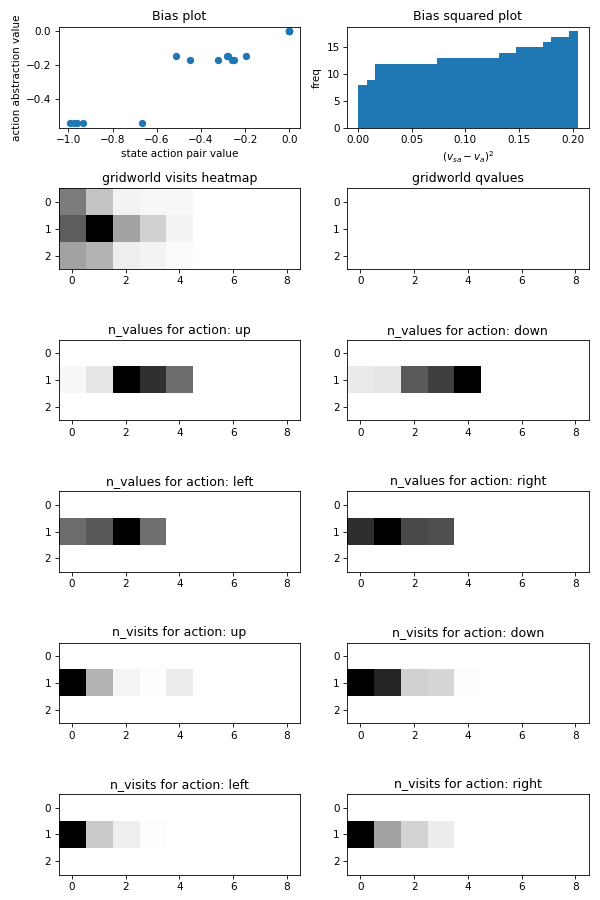

In [12]:
# First plot
%matplotlib notebook
print('(Plotting 1 of 1)')
fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(8, 12))

ax[0, 0].scatter(sa_values, a_values)
ax[0, 0].set_title('Bias plot')
ax[0, 0].set_xlabel('state action pair value')
ax[0, 0].set_ylabel('action abstraction value')
#ax[0, 0].set_ylim((0, 40))

ax[0, 1].hist(bias_squared, cumulative=True, bins=25)
ax[0, 1].set_title('Bias squared plot')
ax[0, 1].set_xlabel(r'$(v_{sa} - v_{a})^2$')
ax[0, 1].set_ylabel('freq')
# plt.ylim((0, 40))

ax[1, 0].imshow(heatmap, cmap='binary')
ax[1, 0].set_title('gridworld visits heatmap')

ax[1, 1].imshow(heatmapQ, cmap='binary')
ax[1, 1].set_title('gridworld qvalues')

ind = 4
for action, n_map in n_maps.items():
    x,y = (floor(ind/2), ind%2)
    ax[x,y].imshow(n_maps[action], cmap='binary')
    ax[x,y].set_title('n_values for action: %s' % action)
    ind += 1

for action, n_map in n_maps.items():
    x,y = (floor(ind/2), ind%2)
    ax[x,y].imshow(nt_maps[action], cmap='binary')
    ax[x,y].set_title('n_visits for action: %s' % action)
    ind += 1

plt.tight_layout()
plt.show()

In [13]:
print(trajectories)

[[T((1, 0),left)-->(1, 0)), T((1, 0),down)-->(2, 0))], [T((1, 0),left)-->(1, 0)), T((1, 0),left)-->(1, 0)), T((1, 0),left)-->(1, 0)), T((1, 0),down)-->(2, 0))], [T((1, 0),left)-->(1, 0)), T((1, 0),left)-->(1, 0)), T((1, 0),up)-->(0, 0))], [T((1, 0),left)-->(1, 0)), T((1, 0),right)-->(1, 1)), T((1, 1),down)-->(2, 1))], [T((1, 0),left)-->(1, 0)), T((1, 0),up)-->(0, 0))], [T((1, 0),left)-->(1, 0)), T((1, 0),left)-->(1, 0)), T((1, 0),right)-->(1, 1)), T((1, 1),right)-->(1, 2)), T((1, 2),down)-->(2, 2))], [T((1, 0),down)-->(2, 0))], [T((1, 0),right)-->(1, 1)), T((1, 1),right)-->(1, 2)), T((1, 2),right)-->(1, 3)), T((1, 3),down)-->(2, 3))], [T((1, 0),right)-->(1, 1)), T((1, 1),down)-->(2, 1))], [T((1, 0),up)-->(0, 0))], [T((1, 0),right)-->(1, 1)), T((1, 1),up)-->(0, 1))], [T((1, 0),left)-->(1, 0)), T((1, 0),down)-->(2, 0))], [T((1, 0),up)-->(0, 0))], [T((1, 0),up)-->(0, 0))], [T((1, 0),right)-->(1, 1)), T((1, 1),up)-->(0, 1))], [T((1, 0),up)-->(0, 0))], [T((1, 0),up)-->(0, 0))], [T((1, 0),ri

In [14]:
agent.estimators[0].approximator.table

defaultdict(<function MDP.estimators.table.__init__.<locals>.<lambda>()>,
            {(1, 0): {'up': -0.995045837202958,
              'down': 0.0,
              'left': 0.0,
              'right': 0.0},
             (2, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (1, 1): {'up': -0.9740561005801573,
              'down': 0.0,
              'left': 0.0,
              'right': 0.0},
             (2, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (0, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (1, 2): {'up': -0.9318181818181818,
              'down': 0.0,
              'left': 0.0,
              'right': 0.0},
             (2, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (1, 3): {'up': -0.6666666666666666,
              'down': 0.0,
              'left': 0.0,
              'right': 0.0},
             (2, 3): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (0, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
   

In [15]:
agent.estimators[1].approximator.table

defaultdict(<function MDP.estimators.table.__init__.<locals>.<lambda>()>,
            {(1, 0): {'up': 0.0027039644573416343,
              'down': 0.004250968543952444,
              'left': 0.08989794948294498,
              'right': 0.10825698906737553},
             (2, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (1, 1): {'up': 0.009711539953319142,
              'down': 0.004974802906840651,
              'left': 0.10208322358976331,
              'right': 0.13232901072580244},
             (2, 1): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (0, 0): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (1, 2): {'up': 0.09694548374797562,
              'down': 0.0324388354696046,
              'left': 0.15641144131817708,
              'right': 0.09510482347706914},
             (2, 2): {'up': 0, 'down': 0, 'left': 0, 'right': 0},
             (1, 3): {'up': 0.07833333333333334,
              'down': 0.03756287099237644,
              'left': 0.08

In [16]:
agent.estimators[2].approximator.table

defaultdict(<function MDP.estimators.table.__init__.<locals>.<lambda>()>,
            {0: {'up': 0.00185052308177456,
              'down': 0.001851929485863565,
              'left': 0.0017465597204167915,
              'right': 0.0012707307805632007}})